# 0. Import the library 

In [1]:
import numpy as np 
import statsmodels.api as sm 
import seaborn as sns 
import pandas as pd 
import matplotlib.pyplot as plt

sns.set()

# 1. Import Data

In [2]:
full_data = pd.read_csv('LaqnData.csv')

In [3]:
full_data

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,GN3,NO,01/01/2011 00:00,17.0,ug m-3,R
1,GN3,NO,02/01/2011 00:00,17.6,ug m-3,R
2,GN3,NO,03/01/2011 00:00,57.1,ug m-3,R
3,GN3,NO,04/01/2011 00:00,45.9,ug m-3,R
4,GN3,NO,05/01/2011 00:00,20.8,ug m-3,R
...,...,...,...,...,...,...
21913,GN3,PM2.5,27/12/2020 00:00,3.8,ug m-3,P
21914,GN3,PM2.5,28/12/2020 00:00,8.7,ug m-3,P
21915,GN3,PM2.5,29/12/2020 00:00,11.3,ug m-3,P
21916,GN3,PM2.5,30/12/2020 00:00,12.4,ug m-3,P


In [4]:
raw_data = full_data.copy()

# 2. Exploratory Data Analysis

## Drop the irrelevant columns

In [5]:
raw_data.columns

Index(['Site', 'Species', 'ReadingDateTime', 'Value', 'Units',
       'Provisional or Ratified'],
      dtype='object')

In [6]:
raw_data = raw_data.drop(['Site', 'Units','Provisional or Ratified'], axis = 1) #Drop Unnecessary Columns 

In [7]:
raw_data.isnull().sum() #Identify any null values for extractions

Species               0
ReadingDateTime       0
Value              2035
dtype: int64

## Convert Columns to the correct data type

In [8]:
raw_data.dtypes #Understand the data types for each colomn

Species             object
ReadingDateTime     object
Value              float64
dtype: object

In [9]:
# Use pandas to change the data type of the date column 
raw_data['ReadingDateTime'] = pd.to_datetime(raw_data['ReadingDateTime']) #No need for hr and minute

In [10]:
raw_data.dtypes

Species                    object
ReadingDateTime    datetime64[ns]
Value                     float64
dtype: object

In [11]:
raw_data.head()

,Species,ReadingDateTime,Value
0,NO,2011-01-01,17.0
1,NO,2011-02-01,17.6
2,NO,2011-03-01,57.1
3,NO,2011-04-01,45.9
4,NO,2011-05-01,20.8


## Pivot the dataset

In [12]:
pivot_data = raw_data.pivot(index="ReadingDateTime", columns="Species", values="Value")

In [13]:
pivot_data.head()

Species,NO,NO2,NOX,O3,PM10,PM2.5
ReadingDateTime,,,,,,
2011-01-01,17.0,40.8,66.80000,24.0,23.8,22.9
2011-01-02,48.3,72.8,146.89999,17.5,30.9,33.5
2011-01-03,2.4,19.5,23.10000,57.7,25.1,NaN
2011-01-04,21.1,29.7,62.10000,41.8,17.7,14.4
2011-01-05,4.8,14.0,21.30000,74.3,20.8,15.6


## Remove null variables

In [14]:
pivot_data.isnull().sum()

Species
NO       235
NO2      235
NOX      235
O3        98
PM10     849
PM2.5    383
dtype: int64

In [15]:
clean_data = pivot_data.dropna(axis = 0)

In [16]:
clean_data.describe()

Species,NO,NO2,NOX,O3,PM10,PM2.5
count,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000
mean,23.308677,35.838867,71.573693,34.335895,19.326466,14.636173
std,24.010993,16.437402,50.577820,15.786343,11.206151,10.801296
min,-1.400000,4.900000,5.300000,-0.500000,3.800000,0.600000
25%,10.300000,23.100000,39.900000,23.200000,12.000000,7.875000
50%,16.950000,33.500000,59.000000,34.600000,15.900000,11.200000
75%,27.325000,45.600000,87.550000,45.600000,22.900000,17.400000
max,327.100010,117.500000,607.900020,83.200000,86.200000,82.000000


In [17]:
clean_data.isnull().sum()

Species
NO       0
NO2      0
NOX      0
O3       0
PM10     0
PM2.5    0
dtype: int64

# 3. Visulising Data

PM2.5 is smaller and lighter than PM10 which means they can go deeper into the lungs and can cause greater damage long term.
They also stay in the air for longer and can travel much further than PM10 particles. 
Fine particle pollution has also been linked to even greater health consequences through harmful cardiovascular and respiratory effects.
PM2.5 will be our man indicator for monitoring pollution levels. 


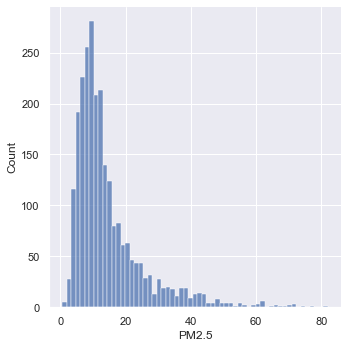

In [18]:
sns.displot(clean_data['PM2.5'])

Any outliners should be removed them as they can strongly affect our results.

## Pair Plot

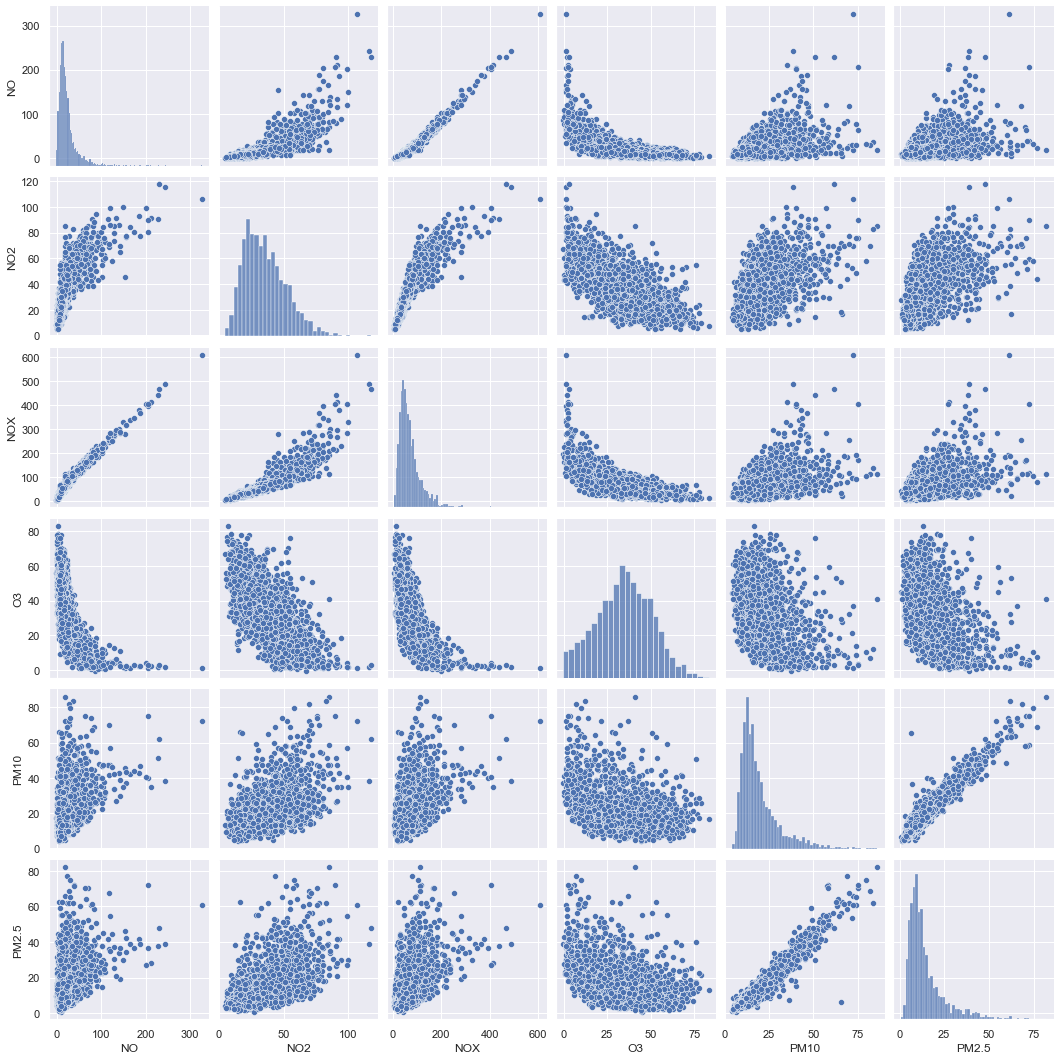

In [19]:
sns.pairplot(clean_data)

## Correlation Plot

<AxesSubplot:xlabel='Species', ylabel='Species'>

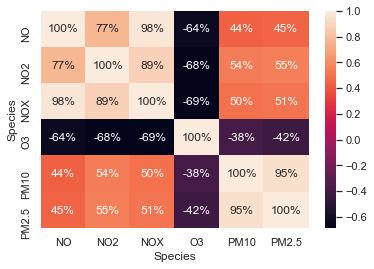

In [20]:
sns.heatmap(clean_data.corr(), annot = True, fmt= '.0%')

Slightly surprising that Ozone (O3) has a negative correlation with the other pollutants. All indicators should rise in the presence of pollution.

# 4. Modelling

## Create Triggers 

In [21]:
# Use the average of PM2.5 to calculate if we 'exceeded' our limit

data_with_targets = clean_data.copy()

data_with_targets.loc[data_with_targets['PM2.5'] <= 14.63, 'Target'] = 0
data_with_targets.loc[data_with_targets['PM2.5'] > 14.63, 'Target'] = 1

data_with_targets

Species,NO,NO2,NOX,O3,PM10,PM2.5,Target
ReadingDateTime,,,,,,,
2011-01-01,17.0,40.8,66.80000,24.0,23.8,22.9,1.0
2011-01-02,48.3,72.8,146.89999,17.5,30.9,33.5,1.0
2011-01-04,21.1,29.7,62.10000,41.8,17.7,14.4,0.0
2011-01-05,4.8,14.0,21.30000,74.3,20.8,15.6,1.0
2011-01-06,27.2,54.9,96.70000,31.1,18.0,15.1,1.0
...,...,...,...,...,...,...,...
2020-12-27,8.1,22.3,34.80000,46.9,6.6,3.8,0.0
2020-12-28,8.8,30.1,43.50000,24.0,11.7,8.7,0.0
2020-12-29,12.3,34.2,53.10000,27.1,13.3,11.3,0.0


## Select the inputs for the regression

In [22]:
unscaled_inputs = data_with_targets.iloc[:,0:6]
targets = data_with_targets.iloc[:, -1]

## Standardize the data

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 

In [24]:
scaler.fit(unscaled_inputs)

StandardScaler()

In [25]:
scaled_inputs = scaler.transform(unscaled_inputs)
scaled_inputs.shape

(2524, 6)

## Build the Model

In [26]:
from sklearn.model_selection import train_test_split
train_test_split(scaled_inputs, targets)

[array([[-0.90845881, -1.33495633, -1.0950386 ,  1.3852757 , -0.56466486,
         -0.36448891],
        [-0.65019259, -1.17066425, -0.85377835,  0.41589147, -1.30547629,
         -1.20714733],
        [ 0.09961259, -0.0084499 ,  0.06775671,  0.22581613, -0.54681398,
         -0.30892902],
        ...,
        [-0.65852375, -1.15849446, -0.8557559 ,  1.58168689, -1.10911663,
         -0.88304794],
        [-0.85430622, -0.6838729 , -0.84191309,  0.10543508, -0.02021308,
         -0.37374889],
        [-0.52939064, -0.92118368, -0.68568719,  1.42329077, -0.88598066,
         -1.01268769]]),
 array([[-0.09200429,  2.17602628,  0.64124419,  1.03680425,  4.13011605,
          3.86732314],
        [-0.10033546,  0.35664361,  0.04402619, -0.47746263,  1.39893172,
          1.26526803],
        [ 0.05379116,  0.5939544 ,  0.23584786, -0.99700189,  1.67562033,
          2.44128582],
        ...,
        [-0.94594907, -1.45665416, -1.16029752,  1.34092479, -0.8949061 ,
         -0.79044811],
  

In [27]:
#Set the train size equal to 0.8 and shuffle the data with a random state
x_train, x_test, y_train, y_test = train_test_split(scaled_inputs, targets, train_size =0.8, random_state = 20) 

In [28]:
print (x_train.shape, y_train.shape)

(2019, 6) (2019,)


# 5. Train the model

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
reg = LogisticRegression()
reg.fit(x_train, y_train)

LogisticRegression()

## Test the model

In [31]:
#Mesure the models accuracy 
reg.score(x_test, y_test)

0.9801980198019802

## Predict the proability for all possible outputs

In [32]:
#Calcaulate the probablity of the PM2.5 emmissions being greater than 1

predicited_proba = reg.predict_proba(x_test)
predicited_proba

array([[6.17565476e-01, 3.82434524e-01],
       [9.99514505e-01, 4.85494591e-04],
       [9.93621617e-01, 6.37838350e-03],
       ...,
       [9.98501787e-01, 1.49821290e-03],
       [7.99487322e-01, 2.00512678e-01],
       [8.88153592e-01, 1.11846408e-01]])

## Checking the model/performance 

In [33]:
y_pred = reg.predict(x_test)

In [34]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

0.019801980198019802


# 7. Saving the model for deployment

In [35]:
import pickle

with open('pollution_model', 'wb') as file:
    pickle.dump(reg, file)

with open('pollution_model', 'wb') as file:
    pickle.dump(scaler, file)

# 8. Evaluation

What would I do differently?

1. I would have more/better explanatory variables. Simply looking at pollution levels is not the best way to build the model. I would include other factors such as temperatures, cloudiness, humidity, the frequency and intensity of precipitation, and wind patterns, each of which can influence air quality.
2. I would use compare different predictive modelling techniques such as decision trees and random forest to see which model is best for this data set. 
